In [2]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 9.0 MB/s 
     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 92 kB 12.2 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 23.3 MB/s 
     |████████████████████████████████| 48.3 MB 1.5 MB/s 
     |████████████████████████████████| 237 kB 79.8 MB/s 
     |████████████████████████████████| 352 kB 52.2 MB/s 
     |████████████████████████████████| 1.1 MB 69.6 MB/s 
     |████████████████████████████████| 99 kB 10.8 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 


In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 1s 0us/step


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42


raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)
class_names = raw_train_ds.class_names #neg, pos
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [6]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [7]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


In [8]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [42]:
text_test = ['this movie sucks']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :10]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :10]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :10]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  3185 19237   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0]


In [29]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [31]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Sequence Outputs Shape:(1, 128, 512)


In [32]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

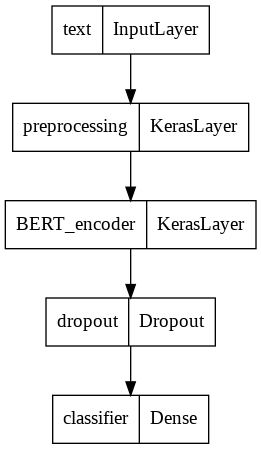

In [34]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [35]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [36]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [37]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [38]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/5
625/625 [==============================] - 170s 262ms/step - loss: 0.4935 - binary_accuracy: 0.7374 - val_loss: 0.4006 - val_binary_accuracy: 0.7956
Epoch 2/5
625/625 [==============================] - 162s 259ms/step - loss: 0.3252 - binary_accuracy: 0.8553 - val_loss: 0.3911 - val_binary_accuracy: 0.8310
Epoch 3/5
625/625 [==============================] - 158s 253ms/step - loss: 0.2498 - binary_accuracy: 0.8949 - val_loss: 0.3925 - val_binary_accuracy: 0.8450
Epoch 4/5
625/625 [==============================] - 158s 253ms/step - loss: 0.1893 - binary_accuracy: 0.9255 - val_loss: 0.4520 - val_binary_accuracy: 0.8528
Epoch 5/5
625/625 [==============================] - 159s 254ms/step - loss: 0.1508 - binary_accuracy: 0.9431 - val_loss: 0.4878 - val_binary_accuracy: 0.8500


In [39]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 89s 114ms/step - loss: 0.4738 - binary_accuracy: 0.8559
Loss: 0.473783016204834
Accuracy: 0.8558800220489502


In [85]:
examples = [
    'this is such an amazing movie!',
    'The movie was great!',
    'The movie was meh.',
    'The movie was okay.',
    'I hated this movie.'
]

In [86]:
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

In [87]:
original_results

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.9994469 ],
       [0.9979984 ],
       [0.9764653 ],
       [0.06026531],
       [0.02140036]], dtype=float32)>